In [1]:
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

#### Load Data

In [3]:
AAPL_data = pd.read_csv('Data/AAPL.csv')

#### Extract train and test data

We will extract the last month's data as the test data and the rest as the train data

We take the date from 2022-02-24 to 2023-01-31 as the train data and make the test data from 2023-02-01 to 2023-02-23

In [4]:
train_df = AAPL_data[(AAPL_data['Date']>'2022-02-23') & (AAPL_data['Date']<='2023-01-31')]
test_df = AAPL_data[(AAPL_data['Date']>'2023-01-31')]

In [5]:
X_train = train_df.drop(['Date','Open'],axis=1)
y_train = np.array(train_df[['Open']]).reshape(-1)
X_test = test_df.drop(['Date','Open'],axis=1)
y_test = np.array(test_df[['Open']]).reshape(-1)

In [6]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1, return_train_score=True)
# Fit the random search model
rf_random.fit(X_train, y_train)


Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, return_train_score=True, verbose=2)

In [7]:
rf_random.best_params_

{'n_estimators': 800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': False}

#### Train and Validation Errors Plot

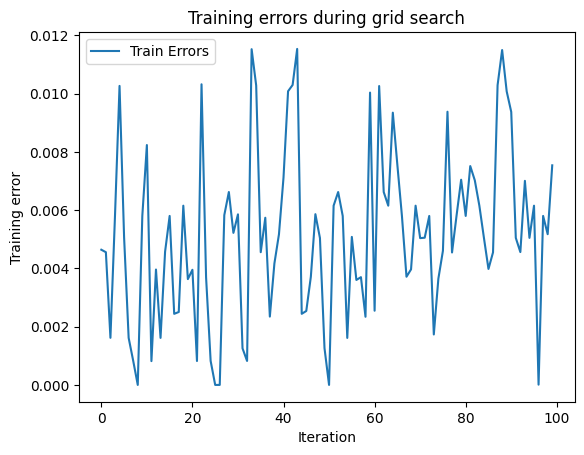

In [8]:
train_errors = 1 - rf_random.cv_results_['mean_train_score']
plt.plot(train_errors, label='Train Errors')
plt.xlabel('Iteration')
plt.ylabel('Training error')
plt.title('Training errors during grid search')
plt.legend()
plt.show()

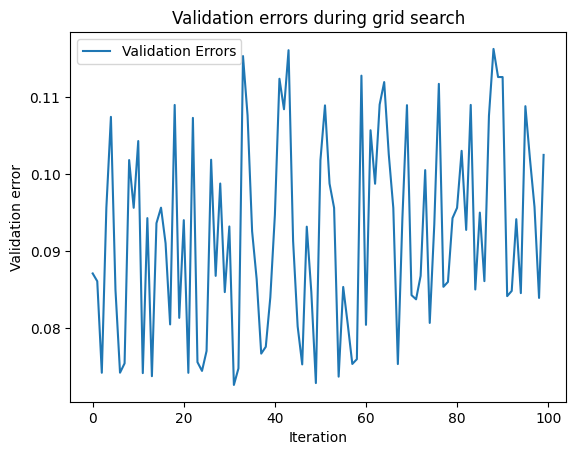

In [9]:
test_errors = 1-rf_random.cv_results_['mean_test_score']
plt.plot(test_errors,label='Validation Errors')
plt.xlabel('Iteration')
plt.ylabel('Validation error')
plt.title('Validation errors during grid search')
plt.legend()
plt.show()

#### Evaluate Model

In [10]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

#### Base Model

In [11]:
base_model = RandomForestRegressor(n_estimators = 10, random_state = 42)
base_model.fit(X_train, y_train)
evaluate(base_model, X_test,y_test)

Model Performance
Average Error: 1.0245 degrees.
Accuracy = 99.32%.


99.32259044599505

#### Best Model

In [12]:
model = RandomForestRegressor(n_estimators=600, min_samples_split=2, min_samples_leaf=2, max_features='sqrt',max_depth=110, bootstrap=False)
model.fit(X_train, y_train)
evaluate(model, X_test,y_test)

Model Performance
Average Error: 0.9761 degrees.
Accuracy = 99.36%.


99.3557226739907

#### Plot Predictions

In [13]:
y_pred = model.predict(X_test)
predict_df = pd.concat([pd.DataFrame(y_pred, columns=['Predict']), pd.DataFrame(y_test, columns=['Actual'])],axis=1)
predict_df.set_index(np.array(AAPL_data[(AAPL_data['Date']>'2023-01-31')].Date),inplace=True)

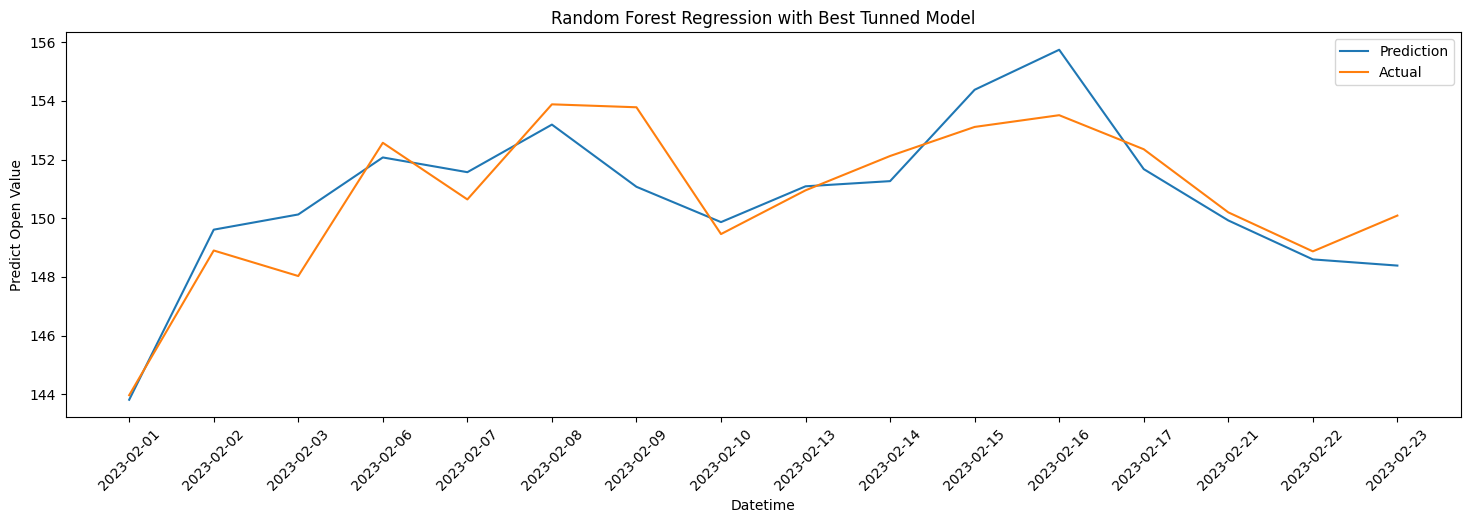

In [14]:

plt.figure(figsize=(18,5))
plt.plot(predict_df['Predict'], label='Prediction')
plt.xticks(rotation=45)
plt.plot(predict_df['Actual'], label='Actual')
plt.title('Random Forest Regression with Best Tunned Model')
plt.xlabel('Datetime')
plt.ylabel('Predict Open Value')
plt.legend()
plt.show()